In [1]:
## working on finalizing a model given reduced set of data columns.
from datetime import datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

import networkx as nx
from networkx.algorithms.components.connected import connected_components

%matplotlib notebook
%timeit

#show up to 100 columns.
pd.set_option('display.max_columns', 100, 'display.max_rows', 200)

In [2]:
## load pickle file with reduced data columns
file_name = 'theorem_reduced.pkl'
reduced_data = pd.read_pickle(file_name)

In [3]:
reduced_data.head()

,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit,Cancelled,BoolPriorProsperLoanee
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,15000.0,True,0.1620,60,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,NaN,NaN,0,False,70000,1,0,0,2,1242,0,0,0,0,0.97,5,True,13901,1,False
981099,15000.0,True,0.1585,60,1,7916.6667,0.35,Other,NaN,32.0,NaN,NaN,0,False,70000,1,0,0,2,2289,0,0,0,0,0.48,3,True,14238,1,False
1025766,4000.0,True,0.2085,36,1,2083.3333,0.53,Employed,Professional,4.0,0.0,NaN,0,False,80000,0,0,0,0,911,0,0,0,0,0.93,5,False,4146,0,True
1003835,10000.0,True,0.1299,36,13,3750.0000,0.14,Employed,Medical Technician,2.0,NaN,NaN,0,False,90000,1,0,0,0,223,0,0,0,0,0.26,1,True,2942,1,False
1011335,20000.0,True,0.1440,60,1,9000.0000,0.16,Employed,Executive,90.0,0.0,NaN,0,False,80000,1,0,1249,1,1264,1,2,0,0,0.81,17,False,8329,0,True


In [4]:
## 18 numerical variables only - show plot for each one. Also include column for cancellation.
numerics = reduced_data[['DolLoanAmountRequested','BorrowerRate','NumMonthsTerm','DolMonthlyIncome','FracDebtToIncomeRatio',\
'NumMonthsEmployed','NumPriorProsperLoansLatePayments',\
'NumTradesOpened6','NumOpenTradesDelinqOrPastDue6','DolTotalBalanceOnPublicRecords','NumRealEstateTrades',\
'DolMonthlyDebt','NumCurrentDelinquencies','NumPublicRecords12','DolAmountDelinquent','PctBankcardUtil',\
'NumTotalInquiries','DaysSinceFirstCredit','Cancelled']]

## 5 boolean variables
booleans = reduced_data[['BoolPartialFundingApproved','BoolIsLender','BoolInGroup','BoolEverWholeLoan','BoolPriorProsperLoanee']]

## 4 categorical variables left: EnumListingCategory, StrEmploymentStatus, StrOccupation, EnumChannelCode

In [153]:
## create one big figure behind subpanels
fig, axes = plt.subplots(6,3,figsize=(12,16), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1),numerics.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, y_jitter=.03, ci = None, x_bins = 500)
    
## LOOKS SIGNIFICANT: DolLoanAmountRequested, DolMonthlyIncome,FracDebtToIncomeRatio,NumMonthsEmployed,NumTradesOpened6,
## NumOpenTradesDelinqOrPastDue6, NumRealEstateTrades, DolMonthlyDebt, NumCurrentDelinquencies, PctBankcardUtil,
## NumTotalInquiries

## DaysSinceFirstCredit has notable parabolic behavior in probability space - may actually be more useful to convert
## to categorical behavior. Actually, same with NumMonthsEmployed?

## NumPriorProsperLoans is a TREMENDOUS predictor of not cancelling - if you've been through the process before, much
## easier to follow through. Not only that, but it should pretty clearly be a boolean cutoff variable - 

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


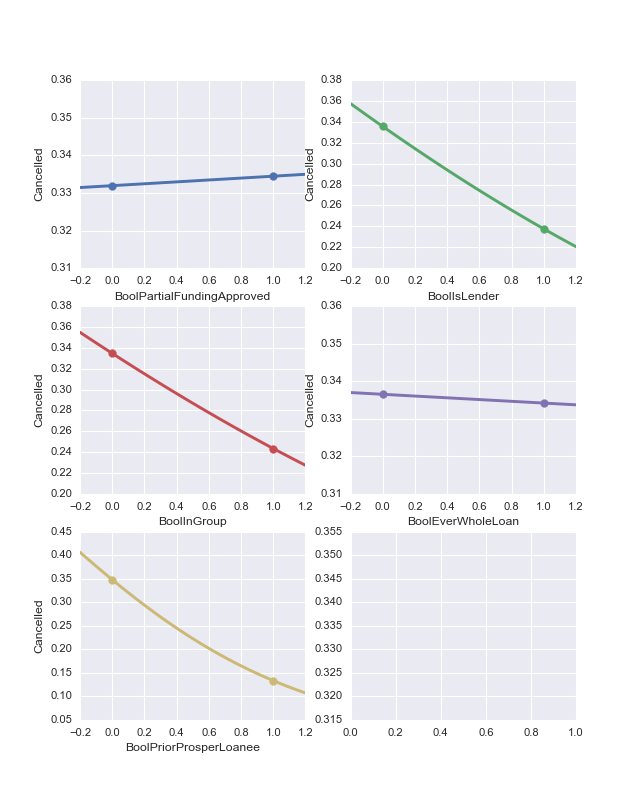

In [17]:
## create one big figure behind subpanels
fig, axes = plt.subplots(3,2,figsize=(8,10), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1), booleans.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 500)
    
## CONCLUSION: BoolPriorProsperLoanee is highly significant, BoolIsLender and BoolInGroup significant, 
## BoolPartialFundingApproved and BoolEverWholeLoan not.

<IPython.core.display.Javascript object>


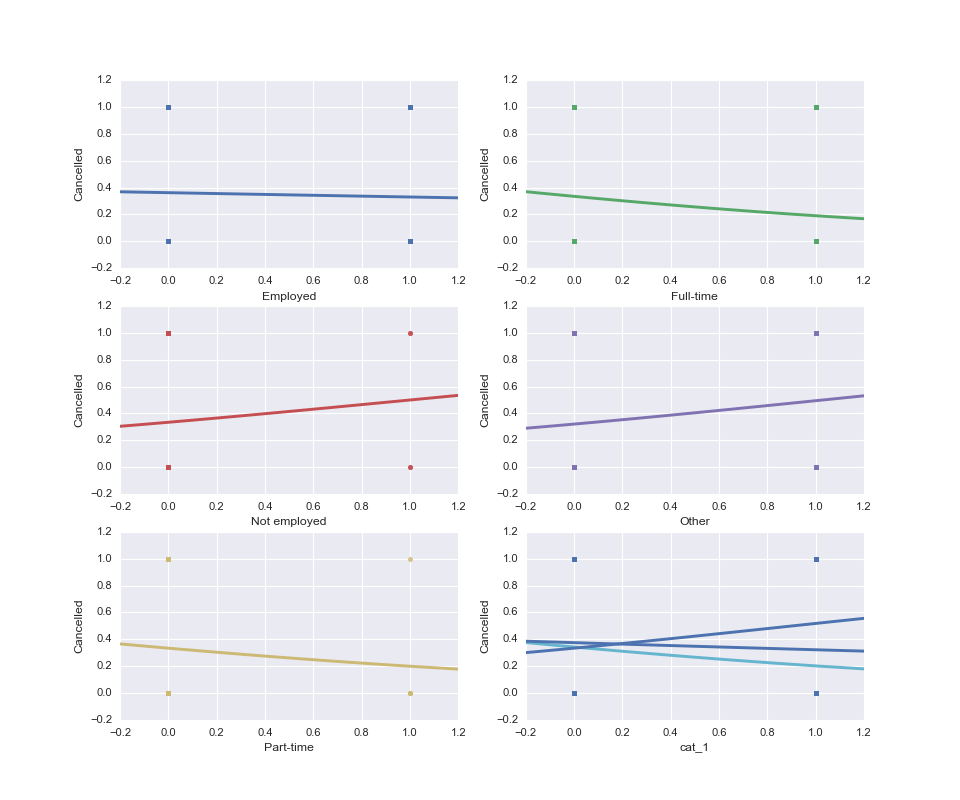

Employed         216678
Other             19544
Self-employed     15624
Full-time           614
Part-time             5
Not employed          4
Name: StrEmploymentStatus, dtype: int64

In [27]:
## 4 categorical variables left: EnumListingCategory, StrEmploymentStatus, StrOccupation, EnumChannelCode
# let's build a dummy variable for each, then see what the associated plots look like...although may have to take a
# different approach for occupation.
enum_listing_dummies = pd.get_dummies(reduced_data['StrEmploymentStatus'])
df = pd.concat([enum_listing_dummies, reduced_data['Cancelled']], axis =1)
fig, axes = plt.subplots(3,2,figsize=(12,10), facecolor='w')
df.head()

for ax, var in zip(axes.reshape(-1), df.columns):
    sns.regplot(ax=ax, x=var, y='Cancelled', data=df, logistic=True, ci = None)
    
reduced_data['StrEmploymentStatus'].value_counts()
    
## massive impact of taking employment status into account - listing "other" dramatically increases chances of not
## following through with loan, whereas having a "full-time" or "self-employed" status strongly increases chances.
## the change with employed looks small, but the sample size is huge, so very likely also significant.

# since this column looks pretty significant, we'll probably end up using OneHotEncoder or get_dummies to split a
# categorical variable into individual columns.

In [5]:
## fold Part-time and Not employed into Other
reduced_data['StrEmploymentStatus'].replace(['Part-time','Not employed'],'Other',inplace = True)
print(reduced_data['StrEmploymentStatus'].value_counts())

Employed         216678
Other             19553
Self-employed     15624
Full-time           614
Name: StrEmploymentStatus, dtype: int64


In [6]:
## For these other booleans with lots of categories, let's just use groupby
g = reduced_data.groupby('EnumListingCategory')
h = [[g['Cancelled'].mean(),g.size()]]
print(h)

## I'm not sure what the categories entail, and the changes aren't massive - leave out of analysis entirely for now.

[[EnumListingCategory
0     0.355263
1     0.322420
2     0.352350
3     0.421997
6     0.374668
7     0.376605
8     0.330864
9     0.343750
11    0.336336
12    0.518182
13    0.343267
14    0.402126
15    0.394137
16    0.371429
17    0.410959
18    0.269542
19    0.431329
20    0.351734
21    0.244094
Name: Cancelled, dtype: float64, EnumListingCategory
0        228
1     195363
2      12638
3       6301
6       2258
7      17756
8        405
9        160
11       333
12       110
13      2718
14      4046
15      5356
16       280
17       146
18      1484
19      1347
20      1413
21       127
dtype: int64]]


In [65]:
## For these other booleans with lots of categories, let's just use groupby
g = reduced_data.groupby('EnumListingCategory')
h = pd.DataFrame([g['Cancelled'].mean(),g.size()]).transpose()
h.columns = 'Cancel Prob','Size'
print(h)

## I'm not sure what the categories entail, and the changes aren't massive - leave out of analysis entirely for now.

                     Cancel Prob      Size
EnumListingCategory                       
0                       0.355263     228.0
1                       0.322420  195363.0
2                       0.352350   12638.0
3                       0.421997    6301.0
6                       0.374668    2258.0
7                       0.376605   17756.0
8                       0.330864     405.0
9                       0.343750     160.0
11                      0.336336     333.0
12                      0.518182     110.0
13                      0.343267    2718.0
14                      0.402126    4046.0
15                      0.394137    5356.0
16                      0.371429     280.0
17                      0.410959     146.0
18                      0.269542    1484.0
19                      0.431329    1347.0
20                      0.351734    1413.0
21                      0.244094     127.0


In [69]:
## For these other booleans with lots of categories, let's just use groupby
g = reduced_data.groupby('StrOccupation')
h = pd.DataFrame([g['Cancelled'].mean(),g.size()]).transpose()
h.columns = 'Cancel Prob','Size'
print(h)
print(reduced_data['StrOccupation'].value_counts())
## I'm not sure what the categories entail, and the changes aren't massive - leave out of analysis entirely for now.

##There are clearly some really rich and probably non-accidental correlations going on with different jobs and loan
##cancellation, especially given the non-negligible sample size in most professions (at least hundreds).

##I'm going to leave occupation out of the analysis for now and seek to reintegrate later.

                                    Cancel Prob     Size
StrOccupation                                           
Accountant/CPA                         0.289733   6292.0
Administrative Assistant               0.305882   4930.0
Analyst                                0.230218   6698.0
Architect                              0.291925    483.0
Attorney                               0.319324   2070.0
Biologist                              0.303191    188.0
Bus Driver                             0.424473   1185.0
Car Dealer                             0.391241    685.0
Chemist                                0.314465    318.0
Civil Service                          0.231803   2679.0
Clergy                                 0.456621    657.0
Clerical                               0.309499   6811.0
Computer Programmer                    0.227259   6442.0
Construction                           0.397276   6240.0
Dentist                                0.505556    360.0
Doctor                         

In [71]:
## For these other booleans with lots of categories, let's just use groupby
g = reduced_data.groupby('EnumChannelCode')
h = pd.DataFrame([g['Cancelled'].mean(),g.size()]).transpose()
h.columns = 'Cancel Prob','Size'
print(h)
 
## clearly, 80000 is the code used for a potential new loanee - no new information, so we can drop this one.

                 Cancel Prob      Size
EnumChannelCode                       
40000               0.347317  115347.0
50000               0.350827   14081.0
70000               0.369273   29095.0
80000               0.133648   16289.0
90000               0.341167   77657.0


In [72]:
reduced_data['BoolPriorProsperLoanee'].value_counts()

## proof that this is equivalent to being a prior loanee - had we known what EnumChannelCode was before, would've been
## slightly faster. oh well.

False    236180
True      16289
Name: BoolPriorProsperLoanee, dtype: int64

In [7]:
## end result of dealing with categoricals dealt with here

## DROP BOOLEAN VARIABLES WITH LOW CORRELATION:
reduced_data.drop('BoolPartialFundingApproved', axis=1, inplace = True)
reduced_data.drop('BoolEverWholeLoan', axis=1, inplace = True)

In [8]:
## DROP CATEGORICAL VARIABLES:
reduced_data.drop('EnumChannelCode', axis=1, inplace = True)
reduced_data.drop('EnumListingCategory', axis=1, inplace = True)

In [9]:
## TEMPORARILY DROP OCCUPATION until we can make rest of model work:
reduced_data.drop('StrOccupation', axis=1, inplace = True)

In [10]:
## let's reposition Cancelled and BoolPriorProsperLoanee to the front.
cols = reduced_data.columns
reorder_cols = np.append(cols[-2:],cols[:-2])
reduced_data = reduced_data[reorder_cols]

In [11]:
reduced_data.head()

,Cancelled,BoolPriorProsperLoanee,DolLoanAmountRequested,BorrowerRate,NumMonthsTerm,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,NumMonthsEmployed,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,DaysSinceFirstCredit
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,
973605,1,False,15000.0,0.1620,60,6000.0000,0.27,Employed,445.0,NaN,NaN,0,False,1,0,0,2,1242,0,0,0,0,0.97,5,13901
981099,1,False,15000.0,0.1585,60,7916.6667,0.35,Other,32.0,NaN,NaN,0,False,1,0,0,2,2289,0,0,0,0,0.48,3,14238
1025766,0,True,4000.0,0.2085,36,2083.3333,0.53,Employed,4.0,0.0,NaN,0,False,0,0,0,0,911,0,0,0,0,0.93,5,4146
1003835,1,False,10000.0,0.1299,36,3750.0000,0.14,Employed,2.0,NaN,NaN,0,False,1,0,0,0,223,0,0,0,0,0.26,1,2942
1011335,0,True,20000.0,0.1440,60,9000.0000,0.16,Employed,90.0,0.0,NaN,0,False,1,0,1249,1,1264,1,2,0,0,0.81,17,8329


In [12]:
len(reduced_data.columns)

25

<IPython.core.display.Javascript object>


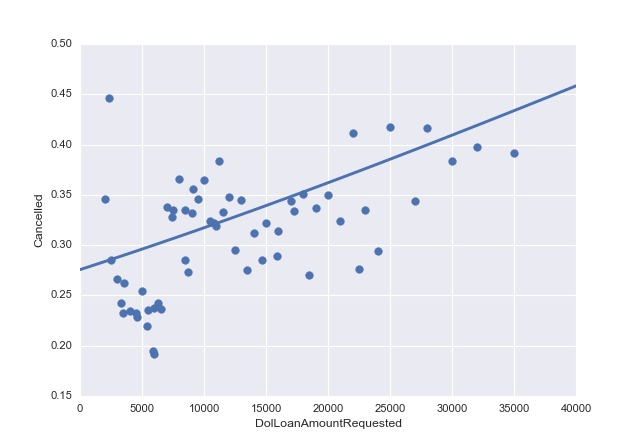

In [154]:
fig, ax = plt.subplots()
sns.regplot(ax=ax, x='DolLoanAmountRequested', y="Cancelled", data=reduced_data, logistic=True, y_jitter=.03, ci = None, x_bins = 500)


In [59]:
## fix logistic modeling 
model1 = linear_model.LogisticRegression()
standard_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler()
x1 = reduced_data['DolLoanAmountRequested'].to_frame()
x1_s = standard_scaler.fit_transform(x1)
y1 = reduced_data['Cancelled']
mm1 = model1.fit(x1_s,y1)

In [72]:
model2 = linear_model.LogisticRegression(C=1000000)
x2 = reduced_data['DolLoanAmountRequested'].to_frame()
y2 = reduced_data['Cancelled']
mm2 = model2.fit(x2,y2)

In [61]:
model3 = linear_model.LogisticRegression()
x3 = x1-x1.mean()[0]
mm3 = model3.fit(x3,y1)

In [73]:
model4 = linear_model.LogisticRegression(C=1000000)
x4 = x1.mean()[0]+x1_s
mm4 = model4.fit(x4,y1)

In [68]:
print(x1_s.mean())
print(x2.mean())
print(x3.mean())
print(x4.mean())
print(x1_s.std())
print(x2.std())
print(x3.std())
print(x4.std())

-1.53102063324e-17
DolLoanAmountRequested    13698.220015
dtype: float64
DolLoanAmountRequested    2.515397e-09
dtype: float64
13698.2200154
1.0
DolLoanAmountRequested    7887.047333
dtype: float64
DolLoanAmountRequested    7887.047333
dtype: float64
1.0


In [69]:
print(mm1.coef_)
print(mm2.coef_)
print(mm3.coef_)
print(mm4.coef_)

[[ 0.15757979]]
[[ -3.33931665e-05]]
[[  1.99170626e-05]]
[[ -5.02614930e-05]]


In [70]:
print(x4.max())

13700.9208769


In [74]:
xrange = np.linspace(2000,35000,331).reshape([331,1])
xrange_2 = (xrange-x2.mean()[0])/(x2.std()[0])

print(mm1.predict_proba(xrange_2.min()))
print(mm1.predict_proba(xrange_2.max()))
print(mm2.predict_proba(xrange.min()))
print(mm2.predict_proba(xrange.max()))
print(mm3.predict_proba(x3.min()))
print(mm3.predict_proba(x3.max()))
print(mm4.predict_proba(13696.7))
print(mm4.predict_proba(x4.max()))

[[ 0.71629408  0.28370592]]
[[ 0.56631375  0.43368625]]
[[ 0.51669851  0.48330149]]
[[ 0.76292684  0.23707316]]
[[ 0.71398503  0.28601497]]
[[ 0.56403511  0.43596489]]
[[ 0.6656146  0.3343854]]
[[ 0.66566181  0.33433819]]


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [75]:
mm1.predict_proba(2.7)

array([[ 0.56634688,  0.43365312]])

In [246]:
mm2.coef_

array([[ -3.33931665e-05]])

In [208]:
pipe = make_pipeline(standard_scaler, model)

In [219]:
pipe.fit(x1,y1)
pipe.predict_proba(x1)

array([[ 0.66070067,  0.33929933],
       [ 0.66070067,  0.33929933],
       [ 0.70810409,  0.29189591],
       ..., 
       [ 0.68272348,  0.31727652],
       [ 0.66070067,  0.33929933],
       [ 0.70187123,  0.29812877]])

In [221]:
pipe[1][1]

TypeError: 'Pipeline' object does not support indexing

In [167]:
## logistic model behaves correctly with respect to BoolPriorProsperLoanee
model = linear_model.LogisticRegression()
x2 = reduced_data['BoolPriorProsperLoanee'].to_frame()
y2 = reduced_data['Cancelled']
mm2 = model.fit(x2,y2)

In [146]:
g=reduced_data.groupby('BoolPriorProsperLoanee')
g['Cancelled'].value_counts(normalize = True)

BoolPriorProsperLoanee  Cancelled
False                   0            0.651791
                        1            0.348209
True                    0            0.866352
                        1            0.133648
Name: Cancelled, dtype: float64

In [169]:
mm2.predict_proba(0)

array([[ 0.65179361,  0.34820639]])

In [148]:
x_range = np.linspace(reduced_data['DolLoanAmountRequested'].min(),reduced_data['DolLoanAmountRequested'].max(),331).reshape([331,1])
probs = mm.predict_proba(x_range)
predicts = mm.predict(x_range)

In [159]:
probs

array([[ 0.51669851,  0.48330149],
       [ 0.51753236,  0.48246764],
       [ 0.51836611,  0.48163389],
       [ 0.51919976,  0.48080024],
       [ 0.52003331,  0.47996669],
       [ 0.52086674,  0.47913326],
       [ 0.52170006,  0.47829994],
       [ 0.52253325,  0.47746675],
       [ 0.52336632,  0.47663368],
       [ 0.52419926,  0.47580074],
       [ 0.52503207,  0.47496793],
       [ 0.52586473,  0.47413527],
       [ 0.52669726,  0.47330274],
       [ 0.52752963,  0.47247037],
       [ 0.52836185,  0.47163815],
       [ 0.52919392,  0.47080608],
       [ 0.53002582,  0.46997418],
       [ 0.53085755,  0.46914245],
       [ 0.53168911,  0.46831089],
       [ 0.5325205 ,  0.4674795 ],
       [ 0.53335171,  0.46664829],
       [ 0.53418273,  0.46581727],
       [ 0.53501356,  0.46498644],
       [ 0.5358442 ,  0.4641558 ],
       [ 0.53667464,  0.46332536],
       [ 0.53750487,  0.46249513],
       [ 0.5383349 ,  0.4616651 ],
       [ 0.53916471,  0.46083529],
       [ 0.53999431,

In [164]:
mm.predict_proba(6000)

array([[ 0.54993091,  0.45006909]])

In [163]:
reduced_data[reduced_data['DolLoanAmountRequested'] == 6000]['Cancelled'].mean()

0.23743272062557125